In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import glob
import os

In [2]:

dir = "/home/akinyilmaz/Desktop/Jupyter_Lab/all/"
train = "train/"
test = "test/"
im = glob.glob(dir + train + "dog/"+"*.jpg")


(374, 500, 3)

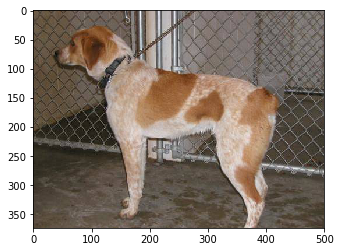

In [26]:
a = plt.imread(im[4])
plt.imshow(a)
a.shape

In [5]:
data_transforms = {
    train: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    test: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(dir, x), 
        transform=data_transforms[x]
    )
    for x in [train,test]
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


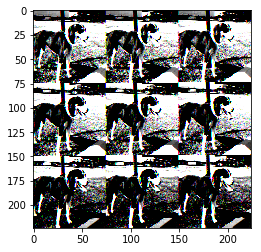

In [40]:
i = image_datasets[train][300][0].numpy()
i.shape
plt.imshow(i.reshape(224,224,3))

In [41]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=32,
        shuffle=False
    )
    for x in [train, test]
}

In [42]:
dataloaders


{'train/': <torch.utils.data.dataloader.DataLoader at 0x7fa9b3844be0>,
 'test/': <torch.utils.data.dataloader.DataLoader at 0x7fa9b3a69a20>}

In [43]:
dset_sizes = {x: len(image_datasets[x]) for x in [train, test]}
dset_classes = image_datasets[train].classes

In [44]:
dset_sizes

{'train/': 400, 'test/': 200}

In [45]:
dset_classes

['cat', 'dog']

In [46]:
model_vgg = models.vgg16(pretrained=True)

In [47]:
for param in model_vgg.parameters():
    param.requires_grad = False
    

In [48]:
model_vgg.classifier[6] = nn.Linear(in_features=4096, out_features=2,bias=True)

In [49]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [54]:
a = [0, 1, 2, 3, 4, 5]
a[0:3]

[0, 1, 2]

In [61]:
for param in model_vgg.classifier[6].parameters():
    param.requires_grad = True

In [62]:
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    k = 0
    for data in dataset:
        print(k)
        inputs,labels = data
        
        inputs , labels = Variable(inputs),Variable(labels)
        x = model_vgg.features(inputs)
        conv_features.extend(x.numpy())
        labels_list.extend(labels.numpy())
        k+=1
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [63]:
conv_feat_train,labels_train = preconvfeat(dataloaders[train])

0
1
2
3


KeyboardInterrupt: 

In [ ]:
len(labels_train), conv_feat_train.shape

In [ ]:
conv_feat_test,labels_test = preconvfeat(dataloaders[test])

In [ ]:
len(labels_test), conv_feat_test.shape

In [ ]:
"""save_array('conv_feat_train.bc',conv_feat_train)
save_array('labels_train.bc',labels_train)
save_array('conv_feat_test.bc',conv_feat_test)
save_array('labels_test.bc',labels_test)"""

In [ ]:
conv_feat_train.shape

In [ ]:
conv_feat_test.shape
model_vgg.classifier[6]

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.Adam(model_vgg.classifier[6].parameters(),lr = lr)

In [ ]:
def data_gen(conv_feat,labels,batch_size=8,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [ ]:
def train_model(model,optimizer,size,conv_feat=None,labels=None,epochs=1):
    for epoch in range(epochs):
        batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=True)
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            
            inputs , classes = Variable(torch.from_numpy(inputs)),Variable(torch.from_numpy(classes))
            inputs = inputs.view(inputs.size(0), -1)

            outputs = model(inputs)

            loss = criterion(outputs,classes)           

            optimizer = optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

        
            _,preds = torch.max(outputs.data,1)
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == classes.data[0])
            #print(running_corrects)
            
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

            

In [ ]:
if model_vgg.classifier[6].out_features == 2:
    train_model(model=model_vgg.classifier,size=dset_sizes[train],conv_feat=conv_feat_train,labels=labels_train,epochs=100,optimizer=optimizer)
